In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
from IPython.display import display

%matplotlib inline
sns.set()

C:\Users\Sam\Anaconda3\lib\site-packages\ggplot\utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
C:\Users\Sam\Anaconda3\lib\site-packages\ggplot\stats\smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
C:\Users\Sam\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [74]:
#grab specific columns of interest
fields = ['decday', 'Mdate', 'datetime', 'wm_gf', 'wm', 'gpp_ANNnight', 'wq_gf', 'TA.y', 'sal', 'PAR', 'VPD', 'PA.x', 
         'PRECIP', 'ustar', 'WT', 'H_gf', 'TW_WATER_10cm']

# import dataset
peat6 = pd.read_csv('data/peat6_all.csv', usecols=fields)

#date time conversions
peat6['datetime'] = pd.to_datetime(peat6['datetime']) #convert datetime to correct type
peat6['year'] = peat6['datetime'].dt.year
peat6['month'] = peat6['datetime'].dt.month
peat6['DOY'] = peat6['datetime'].dt.day

,decday,Mdate,PA.x,ustar,wm,H_gf,wq_gf,wm_gf,gpp_ANNnight,TA.y,PRECIP,PAR,WT,TW_WATER_10cm,VPD,datetime,sal,year,month,DOY
0,287.0208,734425.0208,101.3,NaN,NaN,-19.5946,0.15273,47.7360,-0.576850,16.75,0.0,4.0875,NaN,NaN,0.60032,2010-10-14 00:29:57,NaN,2010,10,14
1,287.0417,734425.0417,101.3,NaN,NaN,-22.7425,0.22760,51.4134,-0.328890,16.00,0.0,4.0875,NaN,NaN,0.52689,2010-10-14 01:00:02,NaN,2010,10,14
2,287.0625,734425.0625,101.3,NaN,NaN,-25.3712,0.13764,82.2245,0.326460,15.05,0.0,4.0875,NaN,NaN,0.41027,2010-10-14 01:30:00,NaN,2010,10,14
3,287.0833,734425.0833,101.3,NaN,NaN,-30.0579,0.32838,92.5906,0.111730,14.10,0.0,4.0875,NaN,NaN,0.30547,2010-10-14 01:59:57,NaN,2010,10,14
4,287.1042,734425.1042,101.3,NaN,NaN,-27.4195,0.22121,103.0439,-0.060777,13.75,0.0,4.0875,NaN,NaN,0.24360,2010-10-14 02:30:02,NaN,2010,10,14


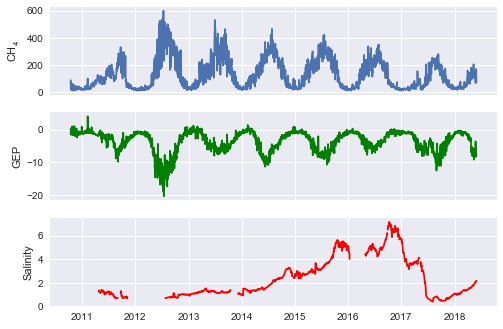

In [62]:
#aggregate to daily cumulative fluxes and mean environmental conditions
peat6['dday'] = peat6['decday'] // 1

daily = pd.DataFrame(peat6.groupby('dday')['wm_gf'].agg('mean')) * 12.01 * 3600 * 24 / 1E6
daily.columns = ['CH4']
daily['GEP'] = peat6.groupby('dday')['gpp_ANNnight'].agg('mean') * 12.01 * 3600 * 24 / 1E6
daily['Sal'] = peat6.groupby('dday')['sal'].agg('mean')
daily['Ta'] = peat6.groupby('dday')['TA.y'].agg('mean')
daily['datetime'] = peat6.groupby('dday')['datetime'].agg('min')

#plot daily fluxes of CH4, GEP, and mean salinity
fig, ax = plt.subplots(3, sharex='col')

ax[0].plot(daily['datetime'], daily['CH4'])
ax[0].set_ylabel('$\mathregular{CH_{4}}$')
ax[1].plot(daily['datetime'], daily['GEP'], color='green')
ax[1].set_ylabel('GEP')
ax[2].plot(daily['datetime'], daily['Sal'], color='red')
ax[2].set_ylabel('Salinity')

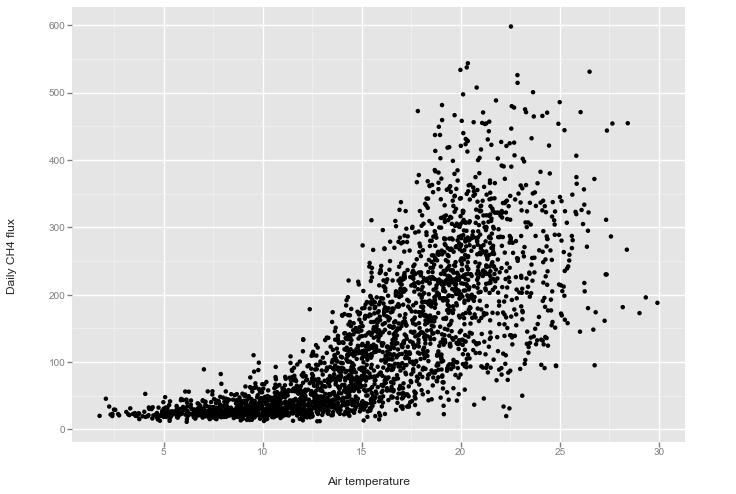

<ggplot: (-9223371845588160722)>

In [65]:
ggplot(daily, aes(x='Ta', y='CH4')) +\
    geom_point() +\
    xlab('Air temperature') + ylab('Daily CH4 flux')

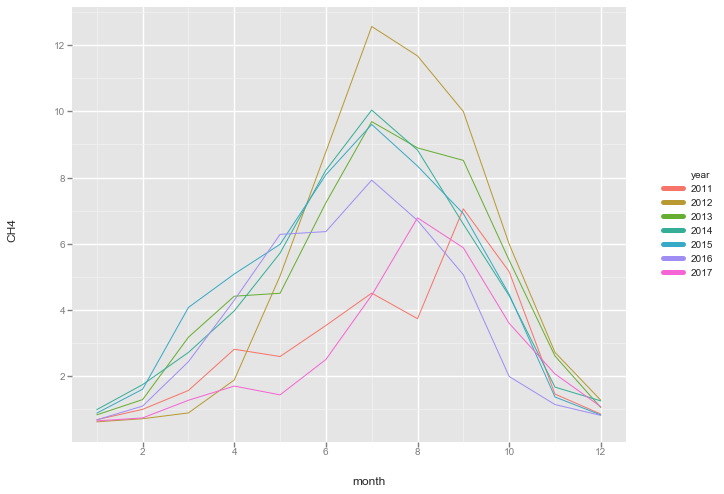

<ggplot: (191277959877)>

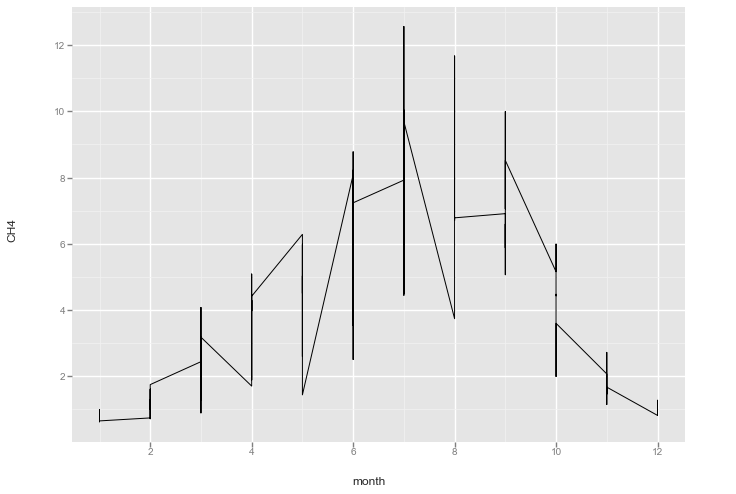

<ggplot: (-9223371845576758314)>

In [258]:
#aggregate
monthly = pd.DataFrame(peat6.groupby(['month', 'year'])['wm_gf'].agg(np.nanmean)) * 12.01 * 3600 * 24 * 30 / 1E9
monthly.columns = ['CH4']
monthly=monthly.reset_index()

#filter incomplete years
monthly = monthly.query('year > 2010 & year < 2018')
monthly['year'] = monthly['year'].astype(object)

g = ggplot(monthly, aes(x='month', y='CH4', colour='year')) + geom_line()
h = ggplot(monthly, aes(x='month', y='CH4')) + geom_line()
display(g, h)
